[View in Colaboratory](https://colab.research.google.com/github/mxchauhan/Capstone/blob/master/3_3_3+Lasso+Regression.ipynb)

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

Ridge regression shrinks parameter estimates, but the estimates never reach exactly 0.  **LASSO** (Least Absolute Shrinkage and Selection Operator), on the other hand, is a model optimization mechanic that works by trying to force small parameter estimates to be equal to zero, effectively dropping them from the model.  This can prevent overfitting, and also works as an embedded feature selection method.  Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and need to optimize processor time, or when you want to arrive at a simpler solution that is easier to interpret.

The cost function to minimize for lasso is _very similar_ to the cost function minimized for ridge. Can you spot the difference?

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

The difference is that rather than penalizing by the sum of *squared* coefficients as ridge does, lasso penalizes by the sum of the *absolute values* of the coefficients.  This means the penalty doesn't increase as swiftly with coefficient size.  Regularization based on the sum of the absolute weights is also called "**L1 regularization**".

Why would penalizing with the sum of the absolute values of coefficients lead to a solution with zero estimates for some parameters, while penalizing with the sum of the squares of coefficients does not?  It all comes down to derivatives.

We encountered derivatives briefly during an earlier assignment on the gradient descent algorithm.  You may recall that a partial derivative represents the sensitivity of one quantity to changes in another quantity.  In the case of both ordinary least squares regression and ridge regression, the derivative used to find the optimal solution is the partial derivative of the cost function relative to the coefficients in $\beta$:

$$\frac{\partial}{\partial\beta}$$

Unfortunately, that won't work for lasso. While we can calculate a derivative for most of the values of $x$ in lasso, there is no derivative where $x=0$.  You can imagine this as our multi-dimensional surface made up of gradients having a big hole in it (the technical term for the hole is a "*discontinuity*"). If the gradient descent algorithm calculates a value that falls in the "hole", it has no idea where to go next.  The model "fails to converge". In other words, it fails to arrive at an optimal solution.

# Fitting Lasso: Coordinate Descent Algorithm

Since basing modeling strategy on a surface with a hole in it is obviously not ideal, lasso regression models are optimized using a coordinate descent algorithm rather than a gradient descent algorithm.  Coordinate descent works like this:

Pick some starting values for $\beta$, often $\beta=0$. 

For each feature $j$ in $\beta$:
* Predict the outcome using all features except for $j$.  
* Look at how the residuals from the model using $\beta_{-j}$ (all betas except $j$) correlate with feature $j$. This correlation is called $\rho_j$.  
* If the correlation falls within an area enclosing 0 defined by $\lambda$, set $\beta_j=0$. (called *soft threshholding*)
* If $\rho_j < \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j + \frac{\lambda}2$
* If $\rho_j > \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j - \frac{\lambda}2$

This will iterate through all features 1 through $j$ on each cycle, then begin again.  Alternatively, the algorithm can be set to choose to exclude a feature at random each iteration, rather than cycling through all features.  Each time a feature is checked, it will shrink a bit from the previous time (unless the feature is already set to 0, in which case it will remain 0).

Continue until the maximum difference between parameter estimates in the previous cycle and the current cycle is less than a pre-determined threshold $tol$.  For SKlearn, $tol$ defaults to 0.0001.

To summarize: Lasso works by iteratively fitting a model to the data while excluding one of the features.  It then checks how well the model reproduces the data, and if the model fit is good enough (with "good enough" determined by $\lambda$) then the excluded feature is deemed unnecessary and its $\beta$ is set to zero, effectively excluding it from the model. Otherwise, the excluded feature's $\beta$ is set using a combination of the correlation of the feature with the model residuals ($\rho_j$) and $\frac{\lambda}2$ and a new iteration begins, using the newly-computed $\beta$ for the previously-excluded feature and excluding a new feature.  This continues until the change in $\beta$ is less than a pre-determined threshold.

Hopefully this demonstrates how lasso can both create overfitting-protection through shrinkage and create sparsity (many parameters set to 0) through feature selection.  Let's see it at work, using the same dataset as previously.

In [0]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [4]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.4500625793011847

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.44363376712897085

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


Checking predictive power using the test set:

In [5]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.44553225151184195
0.4380466345914474


## Regularization parameter: Lasso

The $\lambda$ for lasso can var between 0 (no penalty, acts like OLS) and infinity.  If $\lambda$ is too large, all parameters will be set to zero.  

Create a plot below of how $R^2$ varies across different values of $\lambda$ for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

Do lasso and ridge yield the same $R^2$ for a given lambda value?

Submit your work and discuss the results with your mentor.

In [47]:
# Your code here


data = pd.DataFrame()

data['bias'] = np.arange(0.01, 5, 0.01)

R2Lass = []
R2Ridge = []

for i in data.bias:
  lass = linear_model.Lasso(alpha=i)
  lassfit = lass.fit(X_train2, Y_train)
  r2Lass = lass.score(X_train2, Y_train)
  R2Lass.append(r2Lass)
  
  ridge = ridgeregr = linear_model.Ridge(alpha=i, fit_intercept=False) 
  ridgeregr.fit(X_train2, Y_train)
  r2ridge = ridgeregr.score(X_train2, Y_train)
  R2Ridge.append(r2ridge)
  
data['R2Lass'] = R2Lass
data['R2Ridge'] = R2Ridge
  
data.head()

,bias,R2Lass,R2Ridge
0,0.01,0.573768,0.573972
1,0.02,0.573374,0.573972
2,0.03,0.572752,0.573972
3,0.04,0.572009,0.573972
4,0.05,0.571053,0.573972


In [0]:
data = data.set_index(data.bias)

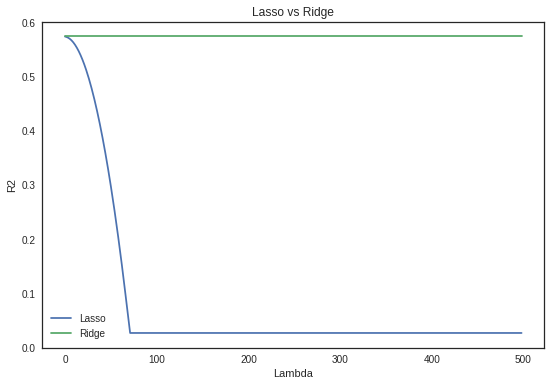

In [46]:
plt.figure(figsize=(9, 6))
plt.plot(data.R2Lass, label='Lasso')
plt.plot(data.R2Ridge, label='Ridge')
plt.ylabel('R2')
plt.xlabel('Lambda')
plt.title("Lasso vs Ridge")
plt.legend()
plt.show()

# Summary

Lasso and ridge regression are both clear improvements on OLS regression.  Ridge regression is an excellent tool to use with correlated features, while lasso is an efficient method of feature selection when dealing with an unmanageably large feature space. 